02450 Project 2

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.datasets as datasets
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

import sklearn.linear_model as lm
from matplotlib.pylab import figure, hist, plot, show, subplot, xlabel, ylabel
from sklearn import model_selection

from dtuimldmtools import *
from dtuimldmtools.statistics.statistics import correlated_ttest



Load data from csv file

In [2]:
cwd = os.getcwd()
data = pd.read_csv(cwd + '/usa_wood_data_formatted.csv')
# print(data.head())  


Clean data by removing columns with significant amount of missing values

In [4]:
removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()
print(data_cleaned.isnull().sum()) # 0 means data is clean

data_arr = np.array(data_cleaned)  # Attributes are columns
attributeNames = [name for name in data_cleaned.columns]
attributeNames = attributeNames[7:12]
attributeNames = np.concatenate((['Wood Type', 'Moisture Content'], attributeNames))
print(attributeNames)

for i in range(data_arr.shape[1]):
    val, count = np.unique(data_arr[:,i], return_counts=True)
    #print(val.shape)        # Print how many unique values of each attribute exist 
                            # Probably dont do one of k coding for first 4 attributes since they have so many unique values

data_adj = data_arr[:,6:12]


for i in range(2):
    OoK = np.zeros([data_arr.shape[0], 1])
    val, count = np.unique(data_arr[:,5 - i], return_counts=True)
    
    for j in range(data_arr.shape[0]):
        if data_arr[j,5-i] == val[0]:
            OoK[j, 0] = 1

    data_adj = np.concatenate((OoK, data_adj), 1)


# for i in range(data_adj.shape[1]):      # Adjust data for zero mean and stddev 1
#     M = data_adj[:,i]
#     data_adj[:,i] = (M - np.mean(M))/(np.std(M))


y = data_adj[:,4]
X = np.concatenate((data_adj[:,0:3], data_adj[:,5:]), 1)
N, M = X.shape

common_species_name                   0
genus                                 0
species                               0
scientific_name                       0
classification                        0
moisture_content                      0
specific_gravity                      0
modulus_of_rupture                    0
modulus_of_elasticity                 0
work_to_maximum_load                  0
compression_parallel_to_grain         0
compression_perpendicular_to_grain    0
shear_parallel_to_grain               0
dtype: int64
['Wood Type' 'Moisture Content' 'modulus_of_rupture'
 'modulus_of_elasticity' 'work_to_maximum_load'
 'compression_parallel_to_grain' 'compression_perpendicular_to_grain']


Linear Regression

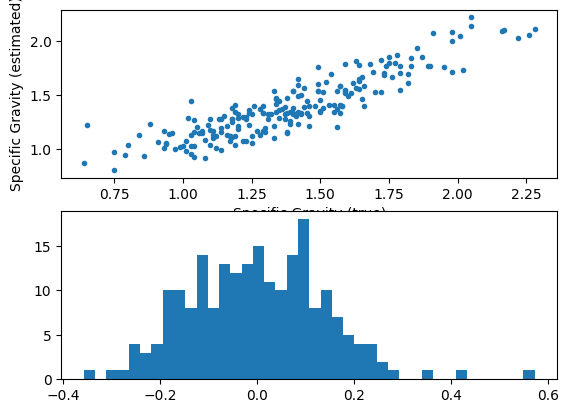

In [5]:
# Fit ordinary least squares regression model
model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X, y)
# Compute model output:
y_est = model.predict(X)
residual = y_est - y

# Display scatter plot
figure()
subplot(2, 1, 1)
plot(y, y_est, ".")
xlabel("Specific Gravity (true)")
ylabel("Specific Gravity (estimated)")
subplot(2, 1, 2)
hist(residual, 40)

show()

Feature Selection 

<generator object _BaseKFold.split at 0x0000015767137430>
Help on function feature_selector_lr in module dtuimldmtools.crossvalidation.implementations:

feature_selector_lr(X, y, cvf=10, features_record=None, loss_record=None, display='')
    Function performs feature selection for linear regression model using
    'cvf'-fold cross validation. The process starts with empty set of
    features, and in every recurrent step one feature is added to the set
    (the feature that minimized loss function in cross-validation.)
    
    Parameters:
    X       training data set
    y       vector of values
    cvf     number of crossvalidation folds
    
    Returns:
    selected_features   indices of optimal set of features
    features_record     boolean matrix where columns correspond to features
                        selected in subsequent steps
    loss_record         vector with cv errors in subsequent steps
    
    Example:
    selected_features, features_record, loss_record = ...
   

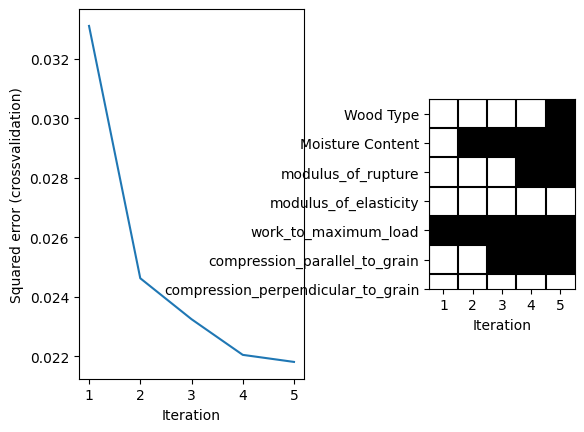

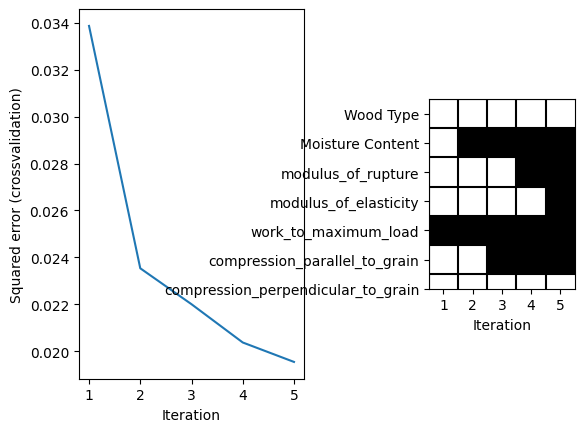

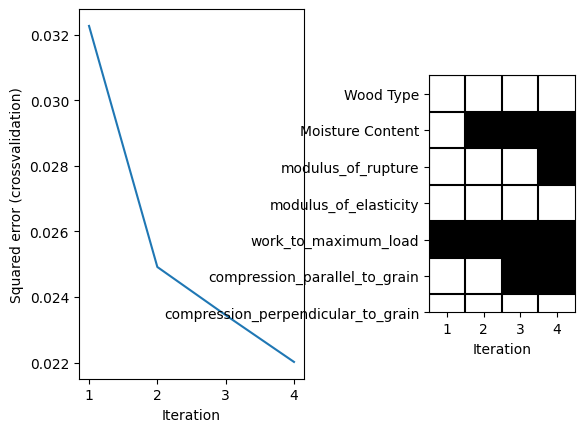

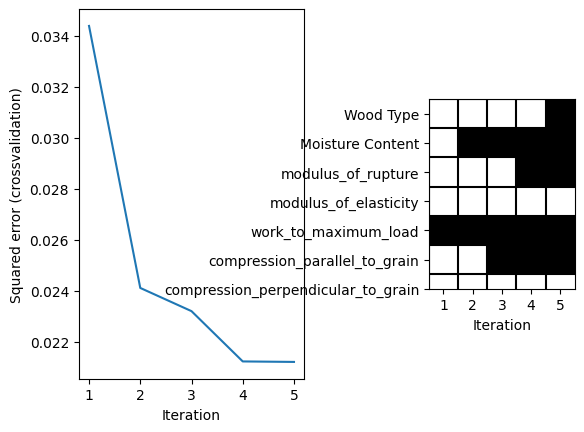

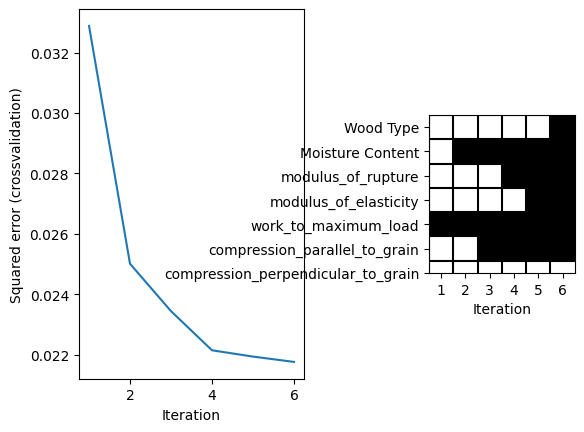

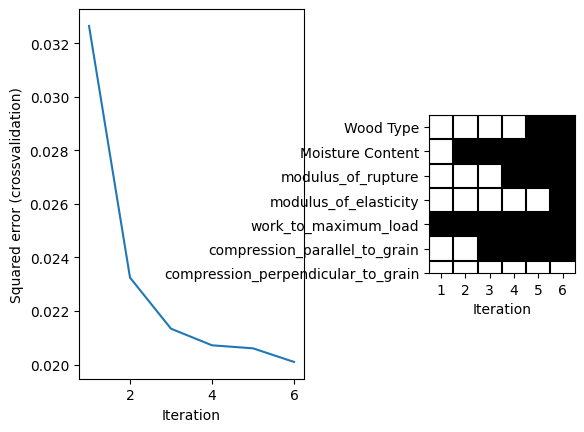

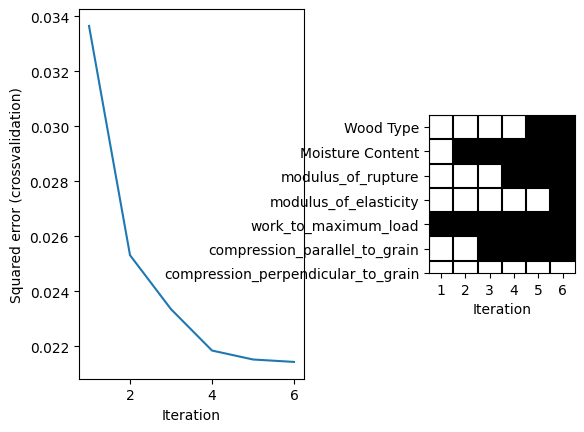

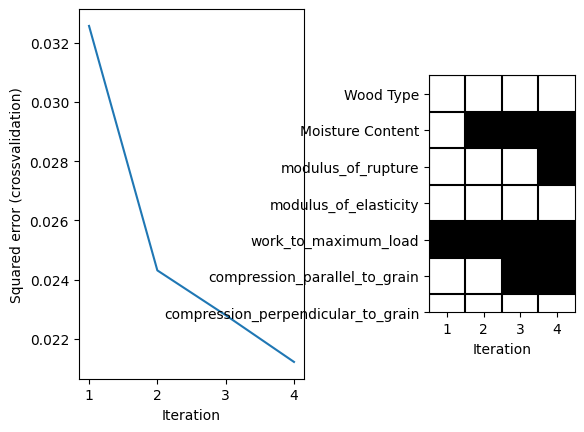

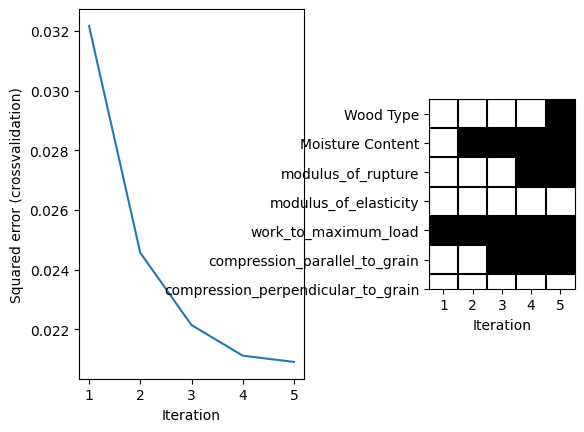

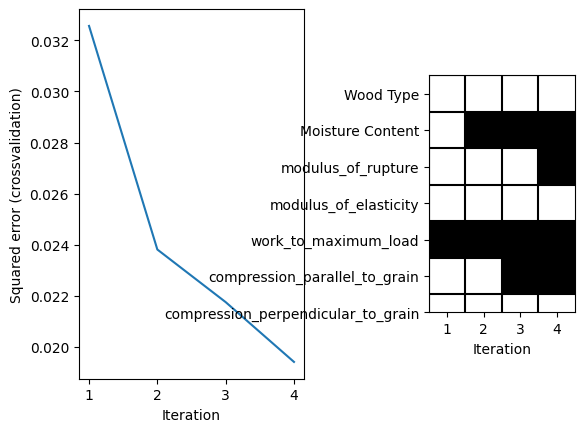

In [6]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
print(CV.split(X))
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    help(feature_selector_lr)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        #clim(-1.5,0)
        xlabel('Iteration')

    # print('Cross validation fold {0}/{1}'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}'.format(test_index))
    # print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))


Finding Optimal Lambda

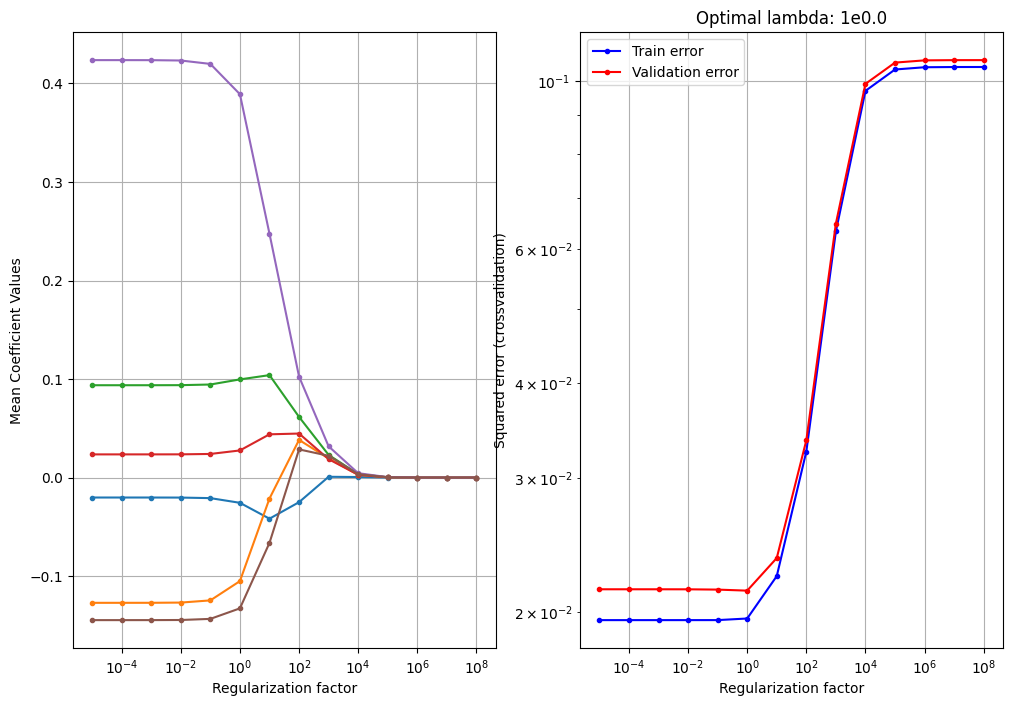

Linear regression without feature selection:
- Training error: 0.019316532534066216
- Test error:     0.021105541748398054
- R^2 train:     0.8093957322557345
- R^2 test:     0.7825830552432906

Regularized linear regression:
- Training error: 0.01938731749885095
- Test error:     0.021179388176327068
- R^2 train:     0.808697267541309
- R^2 test:     0.7818223325415034

The weights at the optimal lambda are 
[ 1.39374141 -0.02557629 -0.1050342   0.09964773  0.02756801  0.38906446
 -0.13268073]


In [7]:
# Add offset attribute

X = np.concatenate((data_adj[:,0:3], data_adj[:,5:]), 1)
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
N, M = X.shape


attributeNames = np.concatenate((["Offset"], attributeNames))
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M-1, K))
mu = np.empty((K, M-2))
sigma = np.empty((K, M-2))
w_noreg = np.empty((M-1, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = np.array(X[train_index], dtype=np.float64) 
    y_train = np.array(y[train_index], dtype=np.float64)
    X_test = np.array(X[test_index], dtype=np.float64)
    y_test = np.array(y[test_index], dtype=np.float64)
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M-1)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("The weights at the optimal lambda are ")
print(mean_w_vs_lambda.T[5,:])